# Embedding command lines as bags of tokens

Amongst the many types of activity captured by host-based agents,
a critical one is the life cycles of processes.
To recall some **Operating Systems 101** of my youth,
*processes instances* are created by the operating system kernel whenever a running program requests the execution of another one.
The process instance stores data on the system resources granted to the execution of all software running concurrently on the host.

A key piece of data attached to each process instance is its **command line**.
This is the name of the program being run, followed by a sequence of _argument_ strings that inform and parameterize the execution of the program.
The information encoded in the command line often speaks of the _intent_ behind the execution of the program,
and inferring user intent is critical for differentiating between regular IT tasks and malicious computing.
Let's thus study the command lines associated to the process instances in the ACME3 dataset,
and examine the patterns of similarity between them.

---

**Goals of this notebook**

1. Wrangle unique objects out of a collection.
1. Tokenize and vectorize command lines.
2. UMAP a set of vectors into a data map.
3. Build a first interactive data map with labels and hover text.

---

In [1]:
import datamapplot as dmp
import glasbey
import json
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.sparse
import shlex
from tqdm.auto import tqdm
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
import vectorizers.utils

In [2]:
tqdm.pandas()

Get the data on the process instances we filtered back in [notebook 0](Gather%20and%20engineer%20dataset.ipynb).

In [3]:
processes = pd.read_parquet("process_filtered.parquet")
processes

,pid_hash,parent_pid_hash,timestamp,hostname,name,cmdline,ptree
0,3F8784056EB55BB295DCAB8C9344254A,BA7EC59E059F8E7B9F75D3BD0D3E85FE,2023-11-05 00:00:00.314092-07:00,ACME-HH-YIM,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
1,B64CB859912B447E83D8C8E619ABCF93,50F07B711DB04C89FF3922CD15C2647B,2023-11-05 00:00:00.377725-07:00,ACME-HH-UWI,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
2,921D6E35B58C5CA571A55D96C16A5D6A,981581F0C573975A7D576645C5B731F0,2023-11-05 00:00:00.436069-07:00,ACME-HH-HGC,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
3,22E2B0D56B1F636B09CBDC86CCDBBD97,483B551ED4FD3BF742CBBD9B343E8117,2023-11-05 00:00:00.586099-07:00,ACME-WS-AZU,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
4,F1F1B598005B90EB45FBF77E74DDFCB8,803022DFF3341FF443B9D49E08D82558,2023-11-05 00:00:00.731733-07:00,ACME-HH-AKA,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
...,...,...,...,...,...,...,...
136701,11D2905584ADEBDB004263B08D3706A1,5B1453B37F079EC6AA910E820C5B6BF1,2023-11-20 15:54:14.616846-08:00,ACME-HH-IKA,usoclient.exe,"""c:\windows\system32\usoclient.exe"" startscan",=usoclient.exe->svchost.exe->services.exe->win...
136702,D8DC51881EDB5C6F7D6239E3DE1A5D93,E283B625D417A1C9584B2D6C9D0C364F,2023-11-20 15:54:14.638486-08:00,ACME-HH-IKA,mousocoreworker.exe,"""c:\windows\system32\mousocoreworker.exe"" -emb...",=mousocoreworker.exe->svchost.exe->services.ex...
136703,521490D4B45E5BDC4BD2CA7081BC06A7,6A37E544F4D9E91016071993B3DC4103,2023-11-20 15:55:23.333011-08:00,ACME-HH-AZH,usoclient.exe,"""c:\windows\system32\usoclient.exe"" startscan",=usoclient.exe->svchost.exe->services.exe->win...
136704,D2211D916C3414FDFBD2663BB9051C84,2C2DB3363D7539099C7869C6BFEEED6B,2023-11-20 15:55:23.349693-08:00,ACME-HH-AZH,mousocoreworker.exe,"""c:\windows\system32\mousocoreworker.exe"" -emb...",=mousocoreworker.exe->svchost.exe->services.ex...


The nifty [SQL query](Gather%20and%20engineer%20dataset.ipynb#sql) that did this filtering put together a normalized approximation to the original command lines in field `cmdline`.
A surprising thing about command lines for obsessive shell users is that most of them are actually highly repetitive.
First, the command lines that get captured are not shell input:
the shell parses a user's input and figures out what programs to spawn off from it.
Second, in most organizations, people don't use shell terminals to do their computing:
they click around in file managers, graphical menus and browsers.
Third, the large majority of programs that run on modern operating systems are started by the system itself,
as part of its service delivery, upkeep and self-auditing.
Thus, most command lines are not typed, they are _scripted_.
As such, there are many less _unique_ distinct command lines than there are process instances.
Let's take a look.

In [4]:
cmdlines_u, i_unique, i_deunique, u_counts = np.unique(
    processes["cmdline"],
    return_index=True,
    return_inverse=True,
    return_counts=True
)
np.savez_compressed("cmdlines_unique.npz", i_unique=i_unique, i_deunique=i_deunique, counts=u_counts)
cmdlines_u.shape

(30994,)

Out of these 30,000-odd command lines,
a large number are not duplicates in the strict sense,
but they are differing only by a single random-looking parameter value that is seen in no other command line
(like the path to a randomly-named temporary file).
We can't collapse these yet, but we do expect they should fall into tight clusters under any useful vectorial representation.

Let's filter the process metadata along command line unicity.

In [5]:
processes_u = processes.iloc[i_unique].copy().reset_index(drop=True)
processes_u

,pid_hash,parent_pid_hash,timestamp,hostname,name,cmdline,ptree
0,45EBAFA4120EBD83795F91B021C2C987,AAF97101D35382DDB72DCD4FEE05818C,2023-11-13 16:22:19.554954-08:00,ACME-HH-AKA,csrss.exe,"""%systemroot%\system32\csrss.exe""",=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe
1,117409566B3CCA5974A355559048FA20,265D22985A544F93F5A936CF17916901,2023-11-05 08:15:58.793352-08:00,ACME-HH-AKA,csrss.exe,"""%systemroot%\system32\csrss.exe"" objectdirect...",=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe
2,71A014969332AF0C1E0FBFC883BEB8FF,8A11985B996D25FAA8FC6F94A809E609,2023-11-07 11:42:03.258287-08:00,ACME-HH-IQS,musnotificationux.exe,"""%systemroot%\system32\musnotificationux.exe"" ...",=musnotificationux.exe->musnotification.exe->s...
3,83FB4E68D3AC8DA9B36A19FF158F9410,EB9FBBB61091C81393AE20E790E727E0,2023-11-13 20:48:15.658330-08:00,ACME-HH-AZH,musnotificationux.exe,"""%systemroot%\system32\musnotificationux.exe"" ...",=musnotificationux.exe->musnotification.exe->s...
4,A5F0F3DB7F64C157C48A7CCBFDCCB9DD,B2DD3FB8C188BC146EECC8FDACD9AAAB,2023-11-14 08:36:33.696670-08:00,ACME-HH-AKA,musnotificationux.exe,"""%systemroot%\system32\musnotificationux.exe"" ...",=musnotificationux.exe->musnotification.exe->s...
...,...,...,...,...,...,...,...
30989,2B69DF1A23610FC8D0E5F50A03883E05,1B084784856C6DEA4CDB32C9BEEB49B2,2023-11-06 10:06:39.091403-08:00,ACME-HH-CLR,bash.exe,"""usr\bin\bash.exe"" --norc -c ""export path=/usr...",=bash.exe->cmd.exe->git-2.42.0.2-64-bit.tmp.ex...
30990,E8574562C96D3A223B0A52389B4EFD3F,75EBCE4A955DA6FB1B76217889B08D31,2023-11-06 12:32:04.250362-08:00,ACME-HH-ATV,mintty.exe,"""usr\bin\mintty.exe"" --nodaemon -o appid=gitfo...",=mintty.exe->git-bash.exe->git-2.42.0.2-64-bit...
30991,4925BFC824A2B984C2AF2C4EBB7F705F,28DBC2E865CEF72D10D49D1B4D16C44E,2023-11-07 08:56:57.908058-08:00,ACME-HH-CCF,vboxheadless.exe,"""vboxheadless.exe""",=vboxheadless.exe->vboxheadless.exe->vboxsvc.e...
30992,73323197ECBC776B25F7554996E55495,DA246B2864851B5489A77B696F4E767B,2023-11-07 11:30:14.549266-08:00,ACME-HH-EAY,vswhere.exe,"""vswhere.exe"" -property catalog_productsemanti...",=vswhere.exe->cmd.exe->cmd.exe->powershell.exe...


To build a vector representation of string data such as our command lines,
we need a way to convert these strings into **sequences of tokens**.
A good token vocabulary will not be too large, and it will _tie together_ the objects expressed with it.
For command lines, a good first stab at tokenization is simply to parse them as a shell would.
the Python standard library has a great tool for that: function `split`, from module `shlex`.
Since the agent sometimes fails to capture the full set of command line arguments,
in particular if quotes get unbalanced,
`shlex.split` gets angry.
In such cases, we try again with a little fix of the command line.

In [6]:
def tokenize_cmdline(cmdline):
    for suffix in ['', '" <broken>']:
        try:
            return shlex.split(cmdline + suffix, posix=False)  # Windows command lines.
        except ValueError:
            pass

    return np.nan

In [7]:
%%time
cmdlines_tokenized = processes_u.set_index("pid_hash")["cmdline"].progress_map(tokenize_cmdline).dropna()
cmdlines_tokenized

  0%|          | 0/30994 [00:00<?, ?it/s]

CPU times: user 1.33 s, sys: 27.9 ms, total: 1.36 s
Wall time: 1.37 s


pid_hash
45EBAFA4120EBD83795F91B021C2C987                  ["%systemroot%\system32\csrss.exe"]
117409566B3CCA5974A355559048FA20    ["%systemroot%\system32\csrss.exe", objectdire...
71A014969332AF0C1E0FBFC883BEB8FF    ["%systemroot%\system32\musnotificationux.exe"...
83FB4E68D3AC8DA9B36A19FF158F9410    ["%systemroot%\system32\musnotificationux.exe"...
A5F0F3DB7F64C157C48A7CCBFDCCB9DD    ["%systemroot%\system32\musnotificationux.exe"...
                                                          ...                        
2B69DF1A23610FC8D0E5F50A03883E05    ["usr\bin\bash.exe", --norc, -c, "export path=...
E8574562C96D3A223B0A52389B4EFD3F    ["usr\bin\mintty.exe", --nodaemon, -o, appid=g...
4925BFC824A2B984C2AF2C4EBB7F705F                                 ["vboxheadless.exe"]
73323197ECBC776B25F7554996E55495    ["vswhere.exe", -property, catalog_productsema...
A54992061BAC1C526BEE5923F4D5E506                                       ["wlrmdr.exe"]
Name: cmdline, Length: 30994, dtype: object

In [8]:
cmdlines_tokenized.to_frame().to_parquet("cmdlines_tokenized.parquet", compression="zstd")

Now that we have a list of strings for each command line,
we can use `vectorizers.NgramVectorizer` to crunch them into a matrix of counts:
each row corresponds to a command line; each column, to a token; each entry,
to the number of times this token was encountered on this command line.
This gives a model called a **bag of words** in the NLP community.

In [9]:
%%time
vz_ngram = vz.NgramVectorizer().fit(cmdlines_tokenized.tolist())
cmdlines_tc = vz_ngram._train_matrix.tocsr()
cmdlines_tc

CPU times: user 1.49 s, sys: 67.3 ms, total: 1.56 s
Wall time: 1.57 s


<30994x20834 sparse matrix of type '<class 'numpy.float32'>'
	with 236529 stored elements in Compressed Sparse Row format>

Bags of words are notoriously fickle given the distribution of tokens:
tokens that are present in a large proportion of objects
(like the word `the` in English sentences)
become a spurious marker of similarity between these objects.
One perspective on this problem is that such [_stop tokens_](https://en.wikipedia.org/wiki/Stop_word)
do dont contribute very many bits of information to the assessment of similarity between the objects.
This perspective gives rise to a method that will measure the information contribution of each token given their marginal distribution,
and downweigh the tokens that are poorly informative.
This method is implemented in `vectorizers.transformers.InformationWeightTransformer`.

In [10]:
cmdlines_iwt = vzt.InformationWeightTransformer().fit_transform(cmdlines_tc)
cmdlines_iwt

<30994x20834 sparse matrix of type '<class 'numpy.float64'>'
	with 236529 stored elements in Compressed Sparse Row format>

We turn these large-dimension vectors into 2D vectors so we can visualize them.
We use UMAP for that:
it is a method based on [manifold learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)
that preserves the _local_ similarity structure between objects.
This can take 10s of seconds up to a few minutes,
depending on your machine.
If you need a hot beverage,
start the cell and go,
it's a good moment.

In [11]:
%%time
bagofwords_dmap = umap.UMAP(metric="hellinger", init="pca", verbose=True).fit_transform(cmdlines_iwt)
bagofwords_dmap.shape

UMAP(angular_rp_forest=True, init='pca', metric='hellinger', verbose=True)
Wed Jul 10 07:51:24 2024 Construct fuzzy simplicial set
Wed Jul 10 07:51:24 2024 Finding Nearest Neighbors
Wed Jul 10 07:51:24 2024 Building RP forest with 14 trees
Wed Jul 10 07:51:27 2024 metric NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	Stopping threshold met -- exiting after 8 iterations
Wed Jul 10 07:51:35 2024 Finished Nearest Neighbor Search


/Users/hamelin/talks-summer-2024/env/main/lib/python3.12/site-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 27979 edges.
It has only fully disconnected 1720 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Wed Jul 10 07:51:36 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jul 10 07:51:41 2024 Finished embedding
CPU times: user 49.7 s, sys: 752 ms, total: 50.5 s
Wall time: 17.1 s


(30994, 2)

Through the execution,
I get the following warning:

```
UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 29124 edges.
It has only fully disconnected 1807 vertices.
Use umap.utils.disconnected_vertices() to identify them.
```

This means that some command lines were expressed over strictly unique tokens:
they could simply not be related to any other.
Without a similarity structure to leverage,
UMAP will not try to produce a projection for these vectors.
They should then be `NaN`.
Let's check.

In [12]:
np.any(np.all(np.isnan(bagofwords_dmap), axis=1))

True

Indeed.
Let's restrict the visualization to the points projected to valid 2D vectors.
<a id="invalid"></a>

In [13]:
i_valid, = np.nonzero(~np.any(np.isnan(bagofwords_dmap), axis=1))
i_valid.shape

(29274,)

Visualizing 30,000-odd points to look for patterns of similarity is meaningless without point annotations to orient the analysis.
Our data mapping technology can make good use of three elements to provide this orientation:

1. Point colors.
2. Floating text annotations.
3. Text to render as tooltips when the mouse hovers over them.

Let's start with the latter.
We will show truncated command lines
(because some of them are _ridiculously_ long &mdash; go see for yourself!)
and, for non-unique command lines,
the number of times they occur in the dataset.

In [14]:
hover_text = (
    processes_u
    .assign(
        count_summary=[
            f"({c}x) " if c > 1 else ""
            for c in u_counts
        ],
        space=" "
    )[
        ["count_summary", "cmdline"]
    ]
    .sum(axis=1)
    .apply(lambda cl: cl[:100] + "[...]" if len(cl) > 100 else cl)
    .rename("hover_text")
)
hover_text.to_frame().to_parquet("hover_text.parquet", compression="zstd")
hover_text

0                        "%systemroot%\system32\csrss.exe"
1        (124x) "%systemroot%\system32\csrss.exe" objec...
2        "%systemroot%\system32\musnotificationux.exe" ...
3        "%systemroot%\system32\musnotificationux.exe" ...
4        "%systemroot%\system32\musnotificationux.exe" ...
                               ...                        
30989    (80x) "usr\bin\bash.exe" --norc -c "export pat...
30990    (18x) "usr\bin\mintty.exe" --nodaemon -o appid...
30991                              (6x) "vboxheadless.exe"
30992    "vswhere.exe" -property catalog_productsemanti...
30993                                   (50x) "wlrmdr.exe"
Name: hover_text, Length: 30994, dtype: object

The other two are most usefully generated in coordination:
this way, the floating text labels can be colored in such a way as to provide an elegant legend of the colors.
The information we want to use to label is the process _name_.
How many of these do we have?

In [15]:
processes_u["name"].value_counts()

name
mscorsvw.exe           9349
msedge.exe             5701
mergehelper.exe        4246
ls.exe                 1632
compattelrunner.exe    1280
                       ... 
azurearcsetup.exe         1
azurearcsystray.exe       1
systemsettings.exe        1
installutil.exe           1
wlrmdr.exe                1
Name: count, Length: 446, dtype: int64

No human eyeball can distinguish 446 color nuances at once.
Let's thus restrict coloring to the $K$ most frequent process names.

In [16]:
K = 25
names_topK = processes["name"].value_counts().head(K).index
names_topK

Index(['svchost.exe', 'conhost.exe', 'taskhostw.exe', 'mscorsvw.exe',
       'microsoftedgeupdate.exe', 'mousocoreworker.exe', 'msedge.exe',
       'sppsvc.exe', 'mergehelper.exe', 'git.exe', 'backgroundtaskhost.exe',
       'bash.exe', 'ngen.exe', 'cmd.exe', 'wmiprvse.exe',
       'compattelrunner.exe', 'wermgr.exe', 'ls.exe', 'googleupdate.exe',
       'reg.exe', 'rundll32.exe', 'ngentask.exe', 'wsqmcons.exe',
       'powershell.exe', 'python.exe'],
      dtype='object', name='name')

We use a maximally wide [palette on perceptual color space](https://onlinelibrary.wiley.com/doi/10.1002/col.20327) using the `glasbey` module.

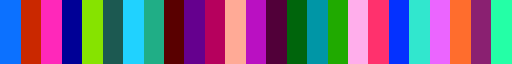

In [17]:
palette = glasbey.create_palette(K, colorblind_safe=True)
ListedColormap(palette)

Map these colors to our labels.

In [18]:
label_color_map = dict(zip(names_topK, palette))
label_color_map["Unlabelled"] = "#dddddd"
label_color_map

{'svchost.exe': '#0c71ff',
 'conhost.exe': '#ca2800',
 'taskhostw.exe': '#ff28ba',
 'mscorsvw.exe': '#000096',
 'microsoftedgeupdate.exe': '#86e300',
 'mousocoreworker.exe': '#1c5951',
 'msedge.exe': '#20d2ff',
 'sppsvc.exe': '#20ae86',
 'mergehelper.exe': '#590000',
 'git.exe': '#65008e',
 'backgroundtaskhost.exe': '#b6005d',
 'bash.exe': '#ffaa96',
 'ngen.exe': '#ba10c2',
 'cmd.exe': '#510039',
 'wmiprvse.exe': '#00650c',
 'compattelrunner.exe': '#0096a6',
 'wermgr.exe': '#20aa00',
 'ls.exe': '#ffaeeb',
 'googleupdate.exe': '#ff316d',
 'reg.exe': '#0431ff',
 'rundll32.exe': '#31e7ce',
 'ngentask.exe': '#eb65ff',
 'wsqmcons.exe': '#ff6d2d',
 'powershell.exe': '#8a2071',
 'python.exe': '#24ffa6',
 'Unlabelled': '#dddddd'}

Associate the labels back to every valid data points.

In [19]:
labels_topK = processes_u["name"].where(processes_u["name"].isin(set(names_topK)), "Unlabelled")
labels_topK.value_counts()

name
mscorsvw.exe               9349
Unlabelled                 6057
msedge.exe                 5701
mergehelper.exe            4246
ls.exe                     1632
compattelrunner.exe        1280
microsoftedgeupdate.exe     736
python.exe                  496
git.exe                     406
ngentask.exe                369
cmd.exe                     271
ngen.exe                    127
reg.exe                      60
powershell.exe               58
googleupdate.exe             53
svchost.exe                  49
conhost.exe                  36
rundll32.exe                 30
taskhostw.exe                14
wermgr.exe                    7
bash.exe                      6
wmiprvse.exe                  4
backgroundtaskhost.exe        3
mousocoreworker.exe           2
sppsvc.exe                    1
wsqmcons.exe                  1
Name: count, dtype: int64

Create this first take on an interactive data map.
Hover over the various points to appraise what command lines get embedded close to which others.

<a id="datamap"></a>

In [20]:
dmp.create_interactive_plot(
    bagofwords_dmap[i_valid],
    labels_topK.iloc[i_valid],
    hover_text=hover_text.iloc[i_valid],
    label_color_map=label_color_map,
    title="Process instances",
    sub_title="as bags of command line tokens",
    darkmode=True,
)

<InteractiveFigure width=100% height=800>

One problem with this data map is that each floating text label is positioned in the center of all the points that support the label.
This is awkward. For instance, `msedge.exe` has point clusters making a rough circle around the center, so it is near none of them.
Other labels support points that do not cluster closely, and thus float in the void, almost useless.
[Notebooks 3](3%20Processes%20as%20bags%20of%20DLLs.ipynb) [and 4](4%20Hosts%20as%20bags%20of%20processes%20over%20tie.ipynb) show cluster-based approaches to labeling the points that can be applied to command lines just as well.
This is left as an exercise to the reader.

Let's save our key results to files: they will be useful in further notebooks.

In [21]:
scipy.sparse.save_npz("cmdlines_iwt.npz", cmdlines_iwt)
np.savez_compressed("cmdlines_bagofwords.npz", datamap=bagofwords_dmap, index_valid=i_valid)
pd.DataFrame({"labels": labels_topK, "hover_text": hover_text}).to_parquet("cmdlines_labels_hovertext.parquet", compression="zstd")
Path("color_map.json").write_text(json.dumps(label_color_map, indent=2), encoding="utf-8")

760